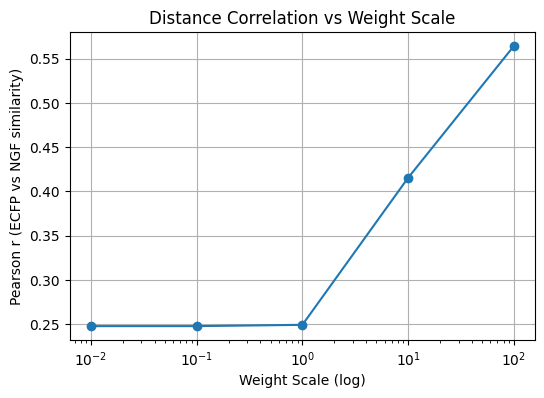

In [3]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch_geometric.datasets import MoleculeNet
from torch_geometric.loader import DataLoader
from torch_geometric.nn.models import NeuralFingerprint
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem
from itertools import combinations
from scipy.stats import pearsonr

# --- 1) Load ESOL and compute ECFP4 ---
dataset = MoleculeNet(root='data/MoleculeNet', name='esol')
smiles_list = [data.smiles for data in dataset]

def ecfp4_fp(smi, radius=2, nBits=2048):
    mol = Chem.MolFromSmiles(smi)
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=nBits)
    arr = np.zeros((nBits,), dtype=int)
    DataStructs.ConvertToNumpyArray(fp, arr)
    return arr

fps_ecfp = np.stack([ecfp4_fp(smi) for smi in smiles_list])

# Sample 2000 random pairs
num_graphs = len(fps_ecfp)
all_pairs = list(combinations(range(num_graphs), 2))
rng = np.random.default_rng(0)
pairs = rng.choice(len(all_pairs), size=2000, replace=False)
selected_pairs = [all_pairs[i] for i in pairs]

# Precompute ECFP Tanimoto
def tanimoto_sim(a, b):
    # compute similarity from binary arrays
    return DataStructs.TanimotoSimilarity(
        AllChem.DataStructs.CreateFromBitString(''.join(map(str, a.tolist()))),
        AllChem.DataStructs.CreateFromBitString(''.join(map(str, b.tolist())))
    )

ecfp_sims = [tanimoto_sim(fps_ecfp[i], fps_ecfp[j]) for i, j in selected_pairs]

# --- 2) NGF embeddings function with detach() ---
def compute_ngf_embeddings(scale, dataset, batch_size=64):
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    ngf = NeuralFingerprint(
        in_channels=dataset.num_node_features,
        hidden_channels=64,
        out_channels=128,
        num_layers=3
    )
    # scale weights
    with torch.no_grad():
        for p in ngf.parameters():
            p.mul_(scale)
    ngf.eval()

    embs = []
    with torch.no_grad():
        for batch in loader:
            e = ngf(batch.x.float(), batch.edge_index, batch.batch)
            # detach before numpy
            embs.append(e.detach().cpu().numpy())
    return np.vstack(embs)

# Continuous Tanimoto
def continuous_tanimoto(x, y):
    dot = np.dot(x, y)
    return dot / (np.dot(x, x) + np.dot(y, y) - dot + 1e-8)

# --- 3) Loop over scales and compute Pearson r ---
scales = [0.01, 0.1, 1, 10, 100]
r_values = []
for scale in scales:
    emb = compute_ngf_embeddings(scale, dataset)
    ngf_sims = [continuous_tanimoto(emb[i], emb[j]) for i, j in selected_pairs]
    r, _ = pearsonr(ecfp_sims, ngf_sims)
    r_values.append(r)

# --- 4) Plot ---
plt.figure(figsize=(6, 4))
plt.plot(scales, r_values, marker='o')
plt.xscale('log')
plt.xlabel('Weight Scale (log)')
plt.ylabel('Pearson r (ECFP vs NGF similarity)')
plt.title('Distance Correlation vs Weight Scale')
plt.grid(True)
plt.show()


In [8]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch_geometric.datasets import MoleculeNet
from torch_geometric.loader import DataLoader
from torch_geometric.nn.models import NeuralFingerprint
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem
from itertools import combinations

# 1) Load full ESOL and sample 200 molecules
full = MoleculeNet(root='data/MoleculeNet', name='esol')
rng = np.random.default_rng(1)
idx_sample = rng.choice(len(full), size=200, replace=False)
subset = [full[i] for i in idx_sample]

# 2) Compute ECFP4 bit-vectors
def ecfp4_fp(mol, radius=2, nBits=2048):
    bitvect = AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=nBits)
    arr = np.zeros((nBits,), dtype=int)
    DataStructs.ConvertToNumpyArray(bitvect, arr)
    return arr

mols     = [Chem.MolFromSmiles(d.smiles) for d in subset]
fps_ecfp = np.stack([ecfp4_fp(m) for m in mols])

# 3) Build 1000 random pairs (i,j)
all_pairs = list(combinations(range(200), 2))
sample_idxs = rng.choice(len(all_pairs), size=1000, replace=False)
selected_pairs = [all_pairs[i] for i in sample_idxs]

# 4) Precompute ECFP Tanimoto similarities
def tanimoto_sim(a, b):
    bv_a = Chem.rdchem.ExplicitBitVect(len(a))
    bv_b = Chem.rdchem.ExplicitBitVect(len(b))
    for idx, bit in enumerate(a): bv_a.SetBit(idx) if bit else None
    for idx, bit in enumerate(b): bv_b.SetBit(idx) if bit else None
    return DataStructs.TanimotoSimilarity(bv_a, bv_b)

ecfp_sims = np.array([tanimoto_sim(fps_ecfp[i], fps_ecfp[j])
                      for i, j in selected_pairs])

# 5) Compute frozen NGF embeddings
loader = DataLoader(subset, batch_size=32, shuffle=False)
ngf = NeuralFingerprint(
    in_channels=full.num_node_features,
    hidden_channels=64,
    out_channels=128,
    num_layers=3
)
with torch.no_grad():
    for p in ngf.parameters(): p.mul_(1.0)
ngf.eval()

embs = []
with torch.no_grad():
    for batch in loader:
        e = ngf(batch.x.float(), batch.edge_index, batch.batch)
        embs.append(e.cpu().numpy())
emb = np.vstack(embs)  # shape [200,128]

# 6) Compute continuous‐Tanimoto on NGF
def cont_tanimoto(x, y):
    dot = np.dot(x, y)
    return dot / (np.dot(x, x) + np.dot(y, y) - dot + 1e-8)

ngf_sims = np.array([cont_tanimoto(emb[i], emb[j])
                     for i, j in selected_pairs])

# 7) Scatter‐plot
plt.figure(figsize=(6,6))
plt.scatter(ecfp_sims, ngf_sims, alpha=0.5, s=10)
plt.xlabel('ECFP4 Tanimoto Similarity')
plt.ylabel('Frozen NGF Continuous Tanimoto')
plt.title('ECFP vs. Frozen NGF Similarities (200‐molecule sample)')
plt.grid(True)
plt.show()


AttributeError: module 'rdkit.Chem.rdchem' has no attribute 'ExplicitBitVect'

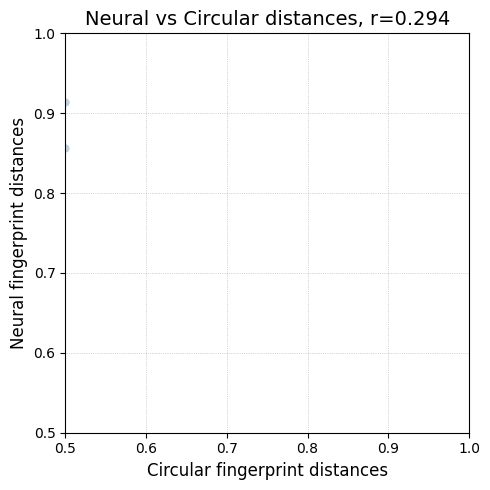

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from torch_geometric.datasets import MoleculeNet
from torch_geometric.loader import DataLoader
from torch_geometric.nn.models import NeuralFingerprint
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem
from itertools import combinations
import torch

# 1) Load full ESOL and sample 200 molecules
full = MoleculeNet(root='data/MoleculeNet', name='esol')
rng = np.random.default_rng(1)
idx_sample = rng.choice(len(full), size=200, replace=False)
subset = [full[i] for i in idx_sample]

# 2) Compute and store the RDKit bit-vectors
fps_ecfp = [AllChem.GetMorganFingerprintAsBitVect(
                Chem.MolFromSmiles(data.smiles),
                radius=2,
                nBits=2048)
            for data in subset]

# 3) Build 1,000 random pairs
all_pairs = list(combinations(range(200), 2))
sample_idxs = rng.choice(len(all_pairs), size=1000, replace=False)
selected_pairs = [all_pairs[i] for i in sample_idxs]

# 4) Precompute ECFP Tanimoto similarities
ecfp_dists = np.array([
    DataStructs.TanimotoSimilarity(fps_ecfp[i], fps_ecfp[j])
    for i, j in selected_pairs
])

# 5) Compute frozen NGF embeddings
loader = DataLoader(subset, batch_size=32, shuffle=False)
ngf = NeuralFingerprint(
    in_channels=full.num_node_features,
    hidden_channels=64,
    out_channels=128,
    num_layers=3
)
# freeze & (optionally) scale
with torch.no_grad():
    for p in ngf.parameters(): p.mul_(1.0)
ngf.eval()

embs = []
with torch.no_grad():
    for batch in loader:
        e = ngf(batch.x.float(), batch.edge_index, batch.batch)
        embs.append(e.cpu().numpy())
emb = np.vstack(embs)  # shape [200, 128]

# 6) Compute Continuous Tanimoto on NGF embeddings
def cont_tanimoto(x, y):
    dot = np.dot(x, y)
    return dot / (np.dot(x, x) + np.dot(y, y) - dot + 1e-8)

ngf_dists = np.array([
    cont_tanimoto(emb[i], emb[j])
    for i, j in selected_pairs
])

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# 1) Compute Pearson r
r, _ = pearsonr(ecfp_dists, ngf_dists)

# 2) Create scatterplot
plt.figure(figsize=(5,5))
plt.scatter(
    ecfp_dists, 
    ngf_dists,
    s=30,                # size of each point
    alpha=0.3,           # transparency
    edgecolors='black',  # thin black outline
    linewidths=0.2,
    facecolor='C0'
)

# 3) Labels, limits, grid
plt.xlabel("Circular fingerprint distances", fontsize=12)
plt.ylabel("Neural fingerprint distances", fontsize=12)
plt.xlim(0.5, 1.0)
plt.ylim(0.5, 1.0)
plt.grid(True, linestyle=':', linewidth=0.5)

# 4) Title with r-value
plt.title(f"Neural vs Circular distances, r={r:.3f}", fontsize=14)

plt.tight_layout()
plt.show()



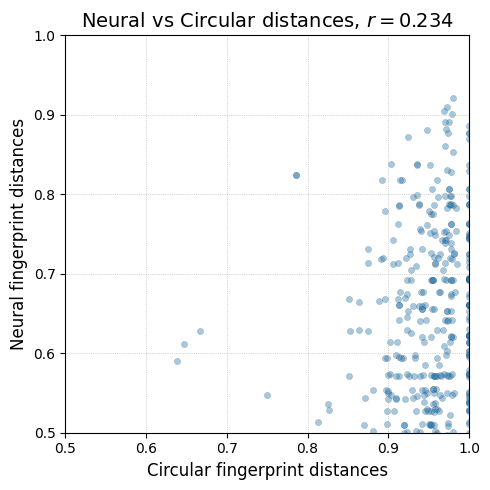

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import torch
from torch_geometric.datasets import MoleculeNet
from torch_geometric.loader import DataLoader
from torch_geometric.nn.models import NeuralFingerprint
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem
from itertools import combinations

# 1) Load ESOL and sample 300 molecules
full_ds = MoleculeNet(root='data/MoleculeNet', name='esol')
rng = np.random.default_rng(42)
idx_sample = rng.choice(len(full_ds), size=300, replace=False)
subset = [full_ds[i] for i in idx_sample]

# 2) Compute RDKit ECFP4 bit-vectors
fps_ecfp = [
    AllChem.GetMorganFingerprintAsBitVect(
        Chem.MolFromSmiles(d.smiles), radius=2, nBits=2048
    ) for d in subset
]

# 3) Build 1500 random pairs
all_pairs    = list(combinations(range(len(subset)), 2))
sample_idxs  = rng.choice(len(all_pairs), size=1500, replace=False)
pairs        = [all_pairs[i] for i in sample_idxs]

# 4) ECFP distances = 1 − Tanimoto similarity
ecfp_dists = np.array([
    1.0 - DataStructs.TanimotoSimilarity(fps_ecfp[i], fps_ecfp[j])
    for i, j in pairs
])

# 5) Frozen NGF embeddings
loader = DataLoader(subset, batch_size=32, shuffle=False)
ngf = NeuralFingerprint(
    in_channels=full_ds.num_node_features,
    hidden_channels=64,
    out_channels=128,
    num_layers=2
)
with torch.no_grad():
    for p in ngf.parameters(): p.mul_(1.0)
ngf.eval()

embs = []
with torch.no_grad():
    for batch in loader:
        embs.append(ngf(batch.x.float(), batch.edge_index, batch.batch).cpu())
emb_mat = torch.cat(embs, dim=0).numpy()  # shape [300,128]

# 6) Continuous‐Tanimoto distances = 1 − cont_sim
def cont_sim(x, y):
    dot = x.dot(y)
    return dot / (x.dot(x) + y.dot(y) - dot + 1e-8)

ngf_dists = np.array([
    1.0 - cont_sim(emb_mat[i], emb_mat[j])
    for i, j in pairs
])

# 7) Pearson r
r, _ = pearsonr(ecfp_dists, ngf_dists)

# 8) Plot
plt.figure(figsize=(5,5))
plt.scatter(
    ecfp_dists, 
    ngf_dists, 
    s=20, 
    alpha=0.4, 
    edgecolors='black', 
    linewidths=0.2, 
    facecolor='C0'
)
plt.xlabel("Circular fingerprint distances", fontsize=12)
plt.ylabel("Neural fingerprint distances",   fontsize=12)
plt.xlim(0.5, 1.0)
plt.ylim(0.5, 1.0)
plt.grid(True, linestyle=':', linewidth=0.5)
plt.title(f"Neural vs Circular distances, $r={r:.3f}$", fontsize=14)
plt.tight_layout()
plt.show()


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations
from scipy.stats import pearsonr

# autograd + rdkit + repo must be on PYTHONPATH
from neuralfingerprint import build_conv_deep_net
from neuralfingerprint.data_util import load_delaney  # ESOL loader
from rdkit.Chem import AllChem, DataStructs

# 1) Load the Delaney (ESOL) data
smiles, y = load_delaney(root='data/Delaney')   # smiles: List[str]

# 2) Compute RDKit ECFP4 bit-vectors
ecfp_bits = [AllChem.GetMorganFingerprintAsBitVect(m, 2, nBits=2048)
             for m in [AllChem.MolFromSmiles(s) for s in smiles]]

# 3) Sample M random pairs
N = len(smiles)
all_pairs = list(combinations(range(N), 2))
rng = np.random.default_rng(0)
M = 2000
idxs = rng.choice(len(all_pairs), size=M, replace=False)
pairs = [all_pairs[i] for i in idxs]

# 4) Build the untrained NGF “pred_fun” at various scales
conv_arch = {
    'fp_length': 128,
    'fp_depth' : 3,
}
vanilla_params = {
    'param_scale': 1.0,      # we’ll sweep this
    'l2_penalty' : 0.0,
}

# This returns (loss_fun, pred_fun, conv_parser)
_, pred_fun, _ = build_conv_deep_net(conv_arch, vanilla_params, vanilla_params['l2_penalty'])

def compute_untrained_embeddings(scale):
    # Sample new random weights at given scale:
    rng = np.random.RandomState(0)
    init_w = rng.randn(pred_fun.n_params) * scale

    # Compute embeddings for all molecules
    embs = np.vstack([
        pred_fun(init_w, [i], batch_size=1)  # pred_fun returns [1,fp_length]
        for i in range(N)
    ])
    return embs

# 5) Precompute ECFP distances
ecfp_dists = np.array([
    1.0 - DataStructs.TanimotoSimilarity(ecfp_bits[i], ecfp_bits[j])
    for i, j in pairs
])

# 6) Sweep scales & plot r vs scale (left panel)
scales = [1e-3, 1e-2, 1e-1, 1, 1e1, 1e2]
r_vals  = []
for s in scales:
    emb = compute_untrained_embeddings(s)
    ngf_dists = np.array([
        1.0 - (emb[i] @ emb[j]) / (np.dot(emb[i], emb[i]) + np.dot(emb[j], emb[j]) - (emb[i] @ emb[j]) + 1e-8)
        for i, j in pairs
    ])
    r, _ = pearsonr(ecfp_dists, ngf_dists)
    r_vals.append(r)

plt.figure(figsize=(5,4))
plt.plot(scales, r_vals, '-o')
plt.xscale('log')
plt.xlabel("Init weight scale (log)")
plt.ylabel("Pearson $r$")
plt.title("Correlation vs. Weight Scale")
plt.grid(True, linestyle=':')
plt.tight_layout()
plt.show()


# 7) Scatterplot at scale=1 (right panel)
emb1 = compute_untrained_embeddings(1.0)
ngf_dists1 = np.array([
    1.0 - (emb1[i] @ emb1[j]) / (np.dot(emb1[i], emb1[i]) + np.dot(emb1[j], emb1[j]) - (emb1[i] @ emb1[j]) + 1e-8)
    for i, j in pairs
])

plt.figure(figsize=(5,5))
plt.scatter(ecfp_dists, ngf_dists1, s=20, alpha=0.4,
            edgecolors='black', linewidths=0.2, facecolor='C0')
r1, _ = pearsonr(ecfp_dists, ngf_dists1)
plt.xlabel("Circular fingerprint distances")
plt.ylabel("Neural fingerprint distances")
plt.xlim(0.5, 1.0)
plt.ylim(0.5, 1.0)
plt.title(f"Neural vs Circular distances, $r={r1:.3f}$")
plt.grid(True, linestyle=':')
plt.tight_layout()
plt.show()
